# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
# !pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [2]:
from collections import namedtuple
import random

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        num_steps = i_step + 1
        ave_loss = loss_accum / num_steps
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler is not None:
            scheduler.step()
        
        print("[%d/%d] Average loss: %f, Train accuracy: %f, Val accuracy: %f" % 
              (epoch+1, num_epochs, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() 
    
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    

        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]

    accuracy = float(correct_samples) / total_samples
    return accuracy
    
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

[1/3] Average loss: 1.404080, Train accuracy: 0.531362, Val accuracy: 0.740632
[2/3] Average loss: 0.698976, Train accuracy: 0.785056, Val accuracy: 0.815439
[3/3] Average loss: 0.586899, Train accuracy: 0.823499, Val accuracy: 0.816804


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
interpol = transforms.InterpolationMode.BILINEAR

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=interpol),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                         std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

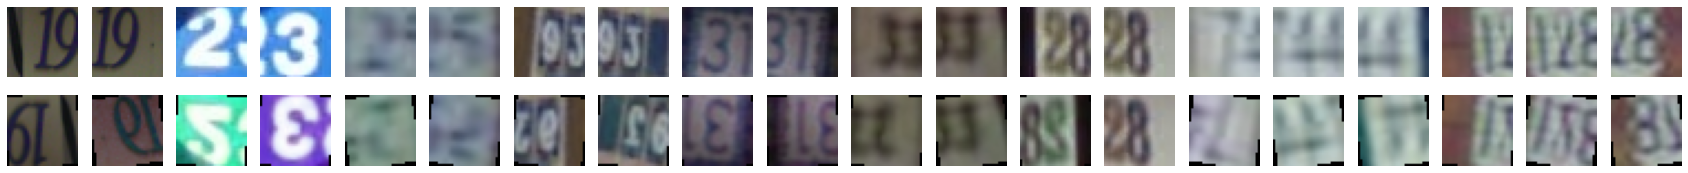

In [10]:
# Based on the visualizations, should we keep all the augmentations?
interpol = transforms.InterpolationMode.BILINEAR

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=interpol),
])

data_vis = dset.SVHN('./')
data_aug_vis = dset.SVHN('./', transform=tfs)

plt.figure(figsize=(30, 3))

num_samples = 20

for i, ((x, _), (x_aug, _)) in enumerate(zip(data_vis, data_aug_vis)):
    if i == num_samples:
        break
    plt.subplot(2, num_samples, i + 1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.grid(False)
    plt.imshow(x_aug)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(10, interpolation=interpol),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 3)

[1/3] Average loss: 0.649365, Train accuracy: 0.802614, Val accuracy: 0.810320
[2/3] Average loss: 0.590494, Train accuracy: 0.821895, Val accuracy: 0.801379
[3/3] Average loss: 0.561949, Train accuracy: 0.830836, Val accuracy: 0.848679


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
lenet_model = nn.Sequential(
            # unlike LeNet we have 3 input channels
            nn.Conv2d(3, 6, 5), # 3@32x32 -> 6@28x28
            nn.Tanh(), # tanh was used as activation function
            nn.MaxPool2d(2, stride=2), # 6@28x28 -> 6@14x14
            nn.Conv2d(6, 16, 5), # 6@14x14 -> 16@10x10
            nn.Tanh(), # see above
            nn.MaxPool2d(2, stride=2), # 16@10x10 -> 16@5x5    
            Flattener(), # 16@5x5 -> 400
            nn.Linear(16*5*5, 120), # 400 -> 120
            nn.Tanh(), # see above
            nn.Linear(120, 84), # 120 -> 84
            nn.Tanh(), # see above
            nn.Linear(84, 10), # 84 -> 10
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

[1/10] Average loss: 1.272670, Train accuracy: 0.572057, Val accuracy: 0.824927
[2/10] Average loss: 0.586082, Train accuracy: 0.821110, Val accuracy: 0.846905
[3/10] Average loss: 0.499753, Train accuracy: 0.847388, Val accuracy: 0.861852
[4/10] Average loss: 0.456860, Train accuracy: 0.859656, Val accuracy: 0.876732
[5/10] Average loss: 0.425587, Train accuracy: 0.870406, Val accuracy: 0.876527
[6/10] Average loss: 0.406156, Train accuracy: 0.876258, Val accuracy: 0.884786
[7/10] Average loss: 0.385440, Train accuracy: 0.881821, Val accuracy: 0.884376
[8/10] Average loss: 0.370052, Train accuracy: 0.886565, Val accuracy: 0.882738
[9/10] Average loss: 0.355855, Train accuracy: 0.891410, Val accuracy: 0.891816
[10/10] Average loss: 0.345730, Train accuracy: 0.893287, Val accuracy: 0.883626


# Подбор гиперпараметров

In [15]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

anneal_coeff = 0.2
batch_size = 64
epoch_num = 10

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [16]:
num_tries = 10
run_record_lenet_sgd = {} 

for i in range(num_tries):
    print('TRY [%d/%d]' % (i+1, num_tries))
        
    lr = 10**random.uniform(-4, 0)
    reg = 10**random.uniform(-7, -3)
    anneal_epochs = random.randint(1, 10)
    
    print('Learning rate: %f' % lr)
    print('Weight decay: %f' % reg)
    print('Anneal epochs: %d' % anneal_epochs)
    
    model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
          )
    model.type(torch.cuda.FloatTensor)
    model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
    
    loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
    
    params = Hyperparams(lr, anneal_epochs, reg)
    res = RunResult(model, train_history, val_history, val_history[-1])
    run_record_lenet_sgd[params] = res
    
    print()

TRY [1/10]
Learning rate: 0.036951
Weight decay: 0.000083
Anneal epochs: 3
[1/10] Average loss: 2.025863, Train accuracy: 0.289049, Val accuracy: 0.558733
[2/10] Average loss: 0.845075, Train accuracy: 0.741170, Val accuracy: 0.809023
[3/10] Average loss: 0.584841, Train accuracy: 0.822766, Val accuracy: 0.851273
[4/10] Average loss: 0.499839, Train accuracy: 0.850357, Val accuracy: 0.863559
[5/10] Average loss: 0.484660, Train accuracy: 0.853616, Val accuracy: 0.866084
[6/10] Average loss: 0.473135, Train accuracy: 0.858410, Val accuracy: 0.869497
[7/10] Average loss: 0.459365, Train accuracy: 0.862113, Val accuracy: 0.870521
[8/10] Average loss: 0.458381, Train accuracy: 0.861891, Val accuracy: 0.870930
[9/10] Average loss: 0.455592, Train accuracy: 0.863700, Val accuracy: 0.871476
[10/10] Average loss: 0.453845, Train accuracy: 0.863478, Val accuracy: 0.872500

TRY [2/10]
Learning rate: 0.475889
Weight decay: 0.000001
Anneal epochs: 1
[1/10] Average loss: 0.987688, Train accuracy: 0

In [17]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record_lenet_sgd.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.88, best hyperparams: Hyperparams(learning_rate=0.3332454418160438, anneal_epochs=1, reg=7.798728578792555e-06)


In [18]:
num_tries = 10
run_record_lenet_adam = {}

for i in range(num_tries):
    print('TRY [%d/%d]' % (i+1, num_tries))
        
    lr = 10**random.uniform(-4, 0)
    reg = 10**random.uniform(-7, -3)
    anneal_epochs = random.randint(1, 10)
    
    print('Learning rate: %f' % lr)
    print('Weight decay: %f' % reg)
    print('Anneal epochs: %d' % anneal_epochs)
    
    model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
          )

    model.type(torch.cuda.FloatTensor)
    model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
    
    loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
    print('Accuracy: %f' % val_history[-1])
    
    params = Hyperparams(lr, anneal_epochs, reg)
    res = RunResult(model, train_history, val_history, val_history[-1])
    run_record_lenet_adam[params] = res
    
    print()

TRY [1/10]
Learning rate: 0.092637
Weight decay: 0.000121
Anneal epochs: 3
[1/10] Average loss: 2.694863, Train accuracy: 0.133331, Val accuracy: 0.116374
[2/10] Average loss: 2.691178, Train accuracy: 0.133280, Val accuracy: 0.111938
[3/10] Average loss: 2.688182, Train accuracy: 0.128997, Val accuracy: 0.115214
[4/10] Average loss: 2.304732, Train accuracy: 0.165751, Val accuracy: 0.163265
[5/10] Average loss: 2.215011, Train accuracy: 0.210149, Val accuracy: 0.304962
[6/10] Average loss: 1.983389, Train accuracy: 0.317613, Val accuracy: 0.369804
[7/10] Average loss: 1.553003, Train accuracy: 0.479234, Val accuracy: 0.547198
[8/10] Average loss: 1.350771, Train accuracy: 0.553527, Val accuracy: 0.595113
[9/10] Average loss: 1.214089, Train accuracy: 0.606542, Val accuracy: 0.656610
[10/10] Average loss: 1.080163, Train accuracy: 0.654950, Val accuracy: 0.691830
Accuracy: 0.691830

TRY [2/10]
Learning rate: 0.009231
Weight decay: 0.000000
Anneal epochs: 7
[1/10] Average loss: 1.710345

In [19]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record_lenet_adam.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.0018824331002005265, anneal_epochs=4, reg=9.71208270890369e-06)


In [20]:
best_model = best_run.model

data_test_size = data_test.data.shape[0]
test_indices = list(range(data_test_size))

test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, 
                                           sampler=test_sampler)

test_accuracy = compute_accuracy(best_model, test_loader)
print("LeNet test accuracy - ", test_accuracy)

LeNet test accuracy -  0.8894821757836509


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [21]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

anneal_coeff = 0.5
batch_size = 64
epoch_num = 10

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(10, interpolation=interpol),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

run_record = {}

In [22]:
num_tries = 20

for i in range(num_tries):
    print('TRY [%d/%d]' % (i+1, num_tries))
        
    lr = 10**random.uniform(-4, 0)
    reg = 10**random.uniform(-7, -3)
    anneal_epochs = random.randint(1, 10)
    
    print('Learning rate: %f' % lr)
    print('Weight decay: %f' % reg)
    print('Anneal epochs: %d' % anneal_epochs)
    
    model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(128*8*8, 10)
          )

    model.type(torch.cuda.FloatTensor)
    model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
    
    loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
    
    params = Hyperparams(lr, anneal_epochs, reg)
    res = RunResult(model, train_history, val_history, val_history[-1])
    run_record[params] = res
    
    print()

TRY [1/20]
Learning rate: 0.000188
Weight decay: 0.000031
Anneal epochs: 9
[1/10] Average loss: 0.785580, Train accuracy: 0.753063, Val accuracy: 0.855914
[2/10] Average loss: 0.440754, Train accuracy: 0.868222, Val accuracy: 0.893045
[3/10] Average loss: 0.374021, Train accuracy: 0.888783, Val accuracy: 0.904102
[4/10] Average loss: 0.332237, Train accuracy: 0.901870, Val accuracy: 0.910655
[5/10] Average loss: 0.295689, Train accuracy: 0.912790, Val accuracy: 0.914886
[6/10] Average loss: 0.272432, Train accuracy: 0.918865, Val accuracy: 0.918913
[7/10] Average loss: 0.252065, Train accuracy: 0.926322, Val accuracy: 0.915842
[8/10] Average loss: 0.241834, Train accuracy: 0.929888, Val accuracy: 0.920756
[9/10] Average loss: 0.222967, Train accuracy: 0.934802, Val accuracy: 0.923896
[10/10] Average loss: 0.178761, Train accuracy: 0.949374, Val accuracy: 0.930175

TRY [2/20]
Learning rate: 0.044424
Weight decay: 0.000000
Anneal epochs: 9
[1/10] Average loss: 3.574878, Train accuracy: 0

In [23]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.94, best hyperparams: Hyperparams(learning_rate=0.0010959958750344466, anneal_epochs=7, reg=0.0005602758043872614)


In [24]:
best_model = best_run.model

epoch_num = 100

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams.learning_rate, weight_decay=best_hyperparams.reg)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_hyperparams.anneal_epochs, gamma=anneal_coeff)
    
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

[1/100] Average loss: 0.223249, Train accuracy: 0.934051, Val accuracy: 0.924510
[2/100] Average loss: 0.215906, Train accuracy: 0.934375, Val accuracy: 0.929015
[3/100] Average loss: 0.210727, Train accuracy: 0.937361, Val accuracy: 0.923009
[4/100] Average loss: 0.208813, Train accuracy: 0.938641, Val accuracy: 0.926626
[5/100] Average loss: 0.201741, Train accuracy: 0.940723, Val accuracy: 0.926899
[6/100] Average loss: 0.201746, Train accuracy: 0.941098, Val accuracy: 0.919732
[7/100] Average loss: 0.196225, Train accuracy: 0.942037, Val accuracy: 0.926421
[8/100] Average loss: 0.154039, Train accuracy: 0.956574, Val accuracy: 0.934407
[9/100] Average loss: 0.144380, Train accuracy: 0.960738, Val accuracy: 0.934202
[10/100] Average loss: 0.140360, Train accuracy: 0.959816, Val accuracy: 0.934817
[11/100] Average loss: 0.136560, Train accuracy: 0.961437, Val accuracy: 0.934885
[12/100] Average loss: 0.133633, Train accuracy: 0.961813, Val accuracy: 0.931199
[13/100] Average loss: 0.

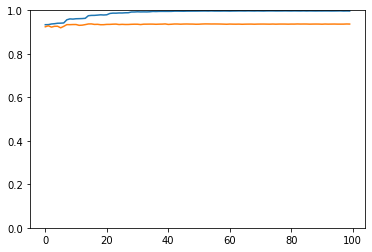

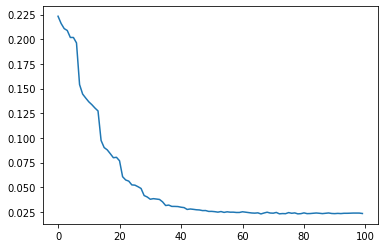

In [25]:
plt.plot(train_history)
plt.plot(val_history)
plt.ylim(0, 1)
plt.show()
plt.plot(loss_history)
plt.show()

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [26]:
data_test_size = data_test.data.shape[0]
test_indices = list(range(data_test_size))

test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, 
                                           sampler=test_sampler)

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.936040258143823


# Визуализация

In [27]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, sampler=indices)
    predictions = np.zeros(len(indices), dtype=int)
    ground_truth = np.zeros(len(indices), dtype=int)
    
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred = torch.argmax(model(x_gpu), dim=1)
        ground_truth[i_step] = y_gpu
        predictions[i_step] = pred
    
    return predictions, ground_truth

def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    confusion_matrix = np.zeros((10, 10), int)
    
    for pred in range(10):
        for gt in range(10):
            confusion_matrix[pred][gt] = np.sum((predictions == pred) & (ground_truth == gt))
    
    return confusion_matrix

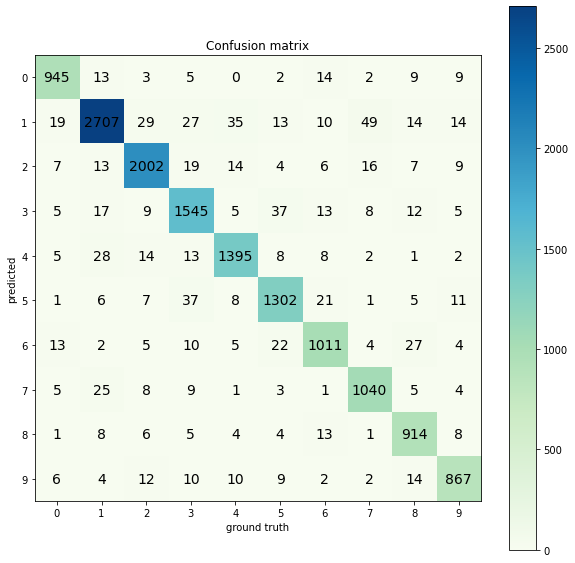

In [28]:
predictions, gt = evaluate_model(best_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

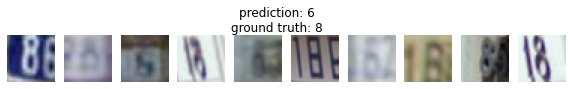

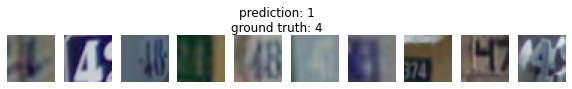

In [29]:
data_train_images = dset.SVHN('./', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(predictions == predicted_class) & (ground_truth == gt_class)]
    title = 'prediction: ' + str(predicted_class) + '\nground truth: ' + str(gt_class)
    visualize_images(indices, data, title)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 4, predictions, gt, np.array(val_indices), data_train_images)